# Imports and Functions

In [1]:
import math 
from sklearn.neural_network import MLPClassifier

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton
import matplotlib.path as path
from matplotlib.colors import ListedColormap
import numpy as np
from numpy import load
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KDTree
%matplotlib notebook

global selection_model
global threshold_low
global threshold_high
threshold_low = -500
threshold_high = 0
import random
from random import randint

global cm
global cm_bright
global wales
global maxiter
global numcoords
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

wales = load('walesoutline1.npy')
wales = path.Path(wales)


maxiter = 21
numcoords = 2
selection_model = 1 #0 for 0.5, 1 for isolated, 2 for random, 3 for best

In [2]:
import math
def normpdf(x, mean, sd):
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

In [3]:
def xnew(x): 
    return (-512+(((x+5)*(512--512))/(51+5)))
def ynew(y): 
    return (-512+(((y+2)*(512--512))/(53+2)))

def eggholder(x):
       
    return (-(x[1]+47)*(math.sin(math.sqrt(abs((x[0]/2)+(x[1]+47))))))-((x[0])*(math.sin(math.sqrt(abs((x[0])+(x[1]+47))))))

def eggholderColor(x, threshold_low, threshold_high):
    
    if threshold_low < eggholder((xnew(x[0]),xnew(x[1]))) <threshold_high:
        return 1
    else:
        return 0

In [4]:
def calculateModel():
    
    global X
    global Z
    global Z_model_pred
    global Znew
    global Zeggholder
    global xx,yy
    global Big_df
    global Big_df_land


    x_min, x_max = -5, 51 
    y_min, y_max = -2, 53
    h = .5  # step size in the mesh

    Coords_df = pd.DataFrame(coords,columns=['XPos','YPos','Type'])
    DT_X_Values = Coords_df.drop(['Type'],axis=1)

    X = DT_X_Values.to_numpy().tolist()
    X = np.array(X)

    DT_Y_Values = Coords_df.drop(['XPos'],axis=1)
    DT_Y_Values = DT_Y_Values.drop(['YPos'],axis=1)
    y = DT_Y_Values.to_numpy().ravel()



    clf = MLPClassifier(alpha=0.3, max_iter=3000, solver = 'lbfgs')
    clf.fit(X, y)
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
    
    Zeggholder = []
    eggholdercoords = np.c_[xx.ravel(), yy.ravel()]
    for i in range(12320):
        Zeggholder.append(eggholderColor(eggholdercoords[i],threshold_low,threshold_high))



    Z_model_prob = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z_model_prob = Z_model_prob.reshape(xx.shape)                                                      #Z is [model_probs]
    Z_model_pred = clf.predict(np.c_[xx.ravel(), yy.ravel()])[:]                        #Z_model_pred is [model_predictions]

    Big_df = pd.DataFrame(xx.ravel(), columns=['xx'])#
    Big_df.insert(1, 'yy',yy.ravel())
    Big_df.insert(2, 'Z_model_predictions', Z_model_pred.ravel())
    Big_df.insert(3, 'Z_model_predictions_flattened', 0)
    Big_df.insert(4, 'Z_model_probs', Z_model_prob.ravel())
    Big_df.insert(5, 'Z_model_probs_flattened_SEA', 0)
    Big_df.insert(6, 'Z_model_probs_flattened_0', 0)
    Big_df.insert(7, 'Surrogate_model_predictions', Zeggholder)
    Big_df.insert(8, 'Surrogate_model_predictions_flattened', 0)

    for i in range(12320):

        if (wales.contains_points([(Big_df.iat[i,0],Big_df.iat[i,1])])[0]):
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_probs']
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = Big_df.iloc[i]['Surrogate_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = Big_df.iloc[i]['Z_model_probs']

        else:
            Big_df.loc[i, 'Z_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = 'SEA'
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = 0

    Z_model_predictions = Big_df["Z_model_predictions"].to_numpy()
    Z_model_predictions_flattened = Big_df["Z_model_predictions_flattened"].to_numpy()
    Z_model_probs = Big_df["Z_model_probs"].to_numpy()
#     Z_model_probs_flattened = Big_df["Z_model_probs_flattened"].to_numpy()
    Surrogate_model_predictions = Big_df["Surrogate_model_predictions"].to_numpy()
    Surrogate_model_predictions_flattened = Big_df["Surrogate_model_predictions_flattened"].to_numpy()

    Big_df_land = Big_df[Big_df['Z_model_predictions_flattened'] != 'SEA']

    Contour_model = Big_df["Z_model_probs_flattened_0"].to_numpy()
    Contour_model = Contour_model.reshape(xx.shape) 


    plt.cla()
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic_r')
    # plt.axis("off")
    plt.grid()
    ax.contourf(xx, yy, Contour_model, 40, cmap=cm, alpha=
                0.4)

    plt.plot()

    plt.show()


In [5]:
def find_isolated_point():
       
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]

    testpoints = tmp_df[['xx','yy']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        if dist>maxdist:
            maxdist = dist
            maxind = ind
            ifinal = i

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)
    plt.plot()
    plt.show()
    fig1.show()
#     print('isolated', testpoints[ifinal])
    return testpoints[ifinal]
    
def find0_5():
    
    tmp_df = Big_df.iloc[(Big_df['Z_model_probs_flattened_0']-0.50).abs().argsort()[:2]]
    value = randint(0, len(tmp_df.index)-1)
    uncertain_coord = [tmp_df.iloc[value]['xx'],tmp_df.iloc[value]['yy']]
        
    ax.scatter(uncertain_coord[0], uncertain_coord[1], c='#00FF00', s=25)
    plt.plot()
    plt.show()    
    fig1.show()
      
#     print('0_5', uncertain_coord)
    return uncertain_coord

def random_point():
    
    tmp_df = Big_df_land.iloc[:, :]
    testpoints = tmp_df[['xx','yy']].to_numpy()
                    
    ifinal = randint(0,len(testpoints.tolist()))
    
    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()
    
    fig1.show()
    
    return testpoints[ifinal]

def best():
    
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]
    score = 0

    testpoints = tmp_df[['xx','yy']].to_numpy()
    testpoints1 = tmp_df[['Z_model_probs']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        prob = testpoints1[i]
        tmp_score = dist*normpdf(prob,0.5,0.05)
        if tmp_score>score:
            ifinal = i
            distfinal = dist
            probfinal = prob
            score = tmp_score

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()

    fig1.show()
    
    find0_5()
    find_isolated_point()
    
    print(distfinal)
    print(probfinal)
    print(score)
    print('best',testpoints[ifinal])

    return testpoints[ifinal]
    
    



In [6]:
def Accuracy():
    
    correctPredictions = 0
    incorrectPredictions = 0

    for i in range(len(Big_df_land.index)):
        if ((Big_df_land.iloc[i]["Z_model_predictions"])==(Big_df_land.iloc[i]["Surrogate_model_predictions"])):
            correctPredictions+=1
        else:
            incorrectPredictions+=1


    accuracy = (correctPredictions)/((
    incorrectPredictions+correctPredictions))
    accuracyArray.append(accuracy)

    print('Accuracy is',accuracy)
    

def printGraph():
    
    xAxis = []
    for i in range(len(accuracyArray)):
        xAxis.append(i+1)

    plt.scatter(xAxis, accuracyArray) 
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy over time')
    plt.ylim(0.3, 1.0)  
    plt.show()

# Plot first graph

experiment:  0


<IPython.core.display.Javascript object>


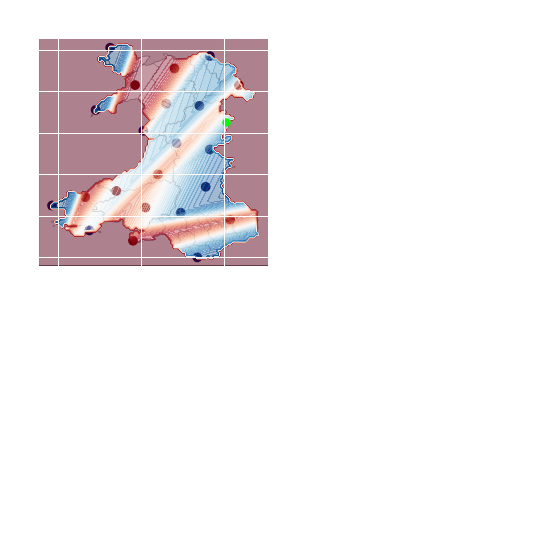

iteration  1
Accuracy is 0.5037492789848106
iteration  2
Accuracy is 0.5041338204191501
iteration  3
Accuracy is 0.5387425495097097
iteration  4
Accuracy is 0.5373966544895212
iteration  5
Accuracy is 0.5206691020957508
iteration  6
Accuracy is 0.5143241684291482
iteration  7
Accuracy is 0.5379734666410305
iteration  8
Accuracy is 0.5387425495097097
iteration  9
Accuracy is 0.5325898865602768
iteration  10
Accuracy is 0.5331666987117862
iteration  11
Accuracy is 0.5235531628532974
iteration  12
Accuracy is 0.5283599307825418
iteration  13
Accuracy is 0.531628532974428
iteration  14
Accuracy is 0.5379734666410305
iteration  15
Accuracy is 0.499134781772736
iteration  16
Accuracy is 0.4866371851567006
iteration  17
Accuracy is 0.48894443376273794
iteration  18
Accuracy is 0.4887521630455682
iteration  19
Accuracy is 0.4754854835608537
iteration  20
Accuracy is 0.4814458757931167
iteration  21
Accuracy is 0.4737550471063257
experiment:  1


<IPython.core.display.Javascript object>


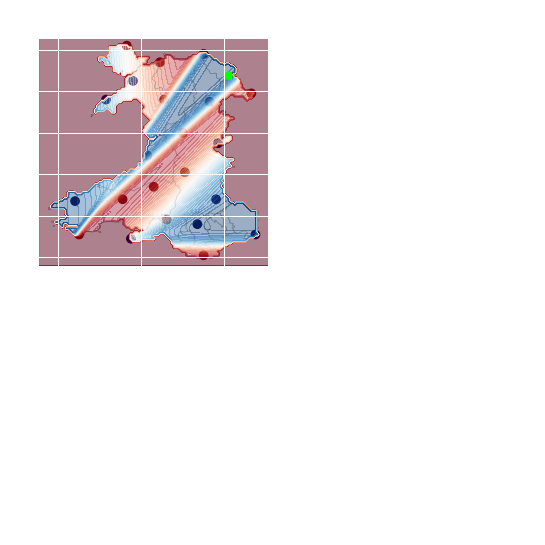

iteration  1
Accuracy is 0.5370121130551817
iteration  2
Accuracy is 0.5097096712170737
iteration  3
Accuracy is 0.5091328590655643
iteration  4
Accuracy is 0.4964429917323592
iteration  5
Accuracy is 0.49009805806575657
iteration  6
Accuracy is 0.49009805806575657
iteration  7
Accuracy is 0.5002884060757546
iteration  8
Accuracy is 0.5000961353585849
iteration  9
Accuracy is 0.50432609113632
iteration  10
Accuracy is 0.49182849452028454
iteration  11
Accuracy is 0.4822149586617958
iteration  12
Accuracy is 0.4979811574697174
iteration  13
Accuracy is 0.49701980388386846
iteration  14
Accuracy is 0.4960584502980196
iteration  15
Accuracy is 0.4845222072678331
iteration  16
Accuracy is 0.48567583157085176
iteration  17
Accuracy is 0.4745241299750048
iteration  18
Accuracy is 0.47971543933858873
iteration  19
Accuracy is 0.49490482599500096
iteration  20
Accuracy is 0.48740626802537973
iteration  21
Accuracy is 0.485483560853682
experiment:  2


<IPython.core.display.Javascript object>


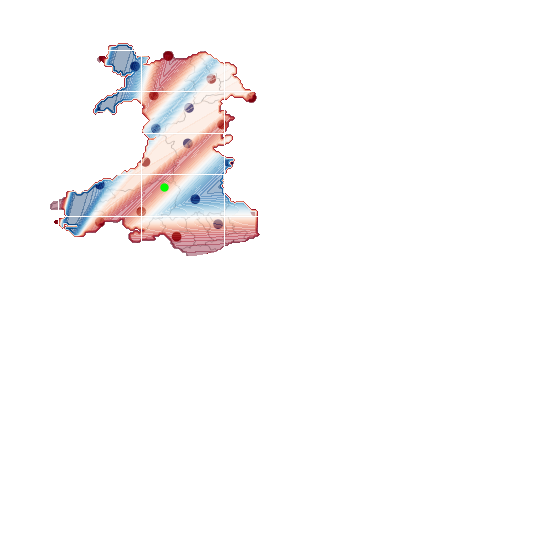

iteration  1
Accuracy is 0.49740434531820804
iteration  2
Accuracy is 0.4952893674293405
iteration  3
Accuracy is 0.49817342818688715
iteration  4
Accuracy is 0.4983656989040569
iteration  5
Accuracy is 0.49817342818688715
iteration  6
Accuracy is 0.49855796962122667
iteration  7
Accuracy is 0.49894251105556625
iteration  8
Accuracy is 0.5004806767929244
iteration  9
Accuracy is 0.49663526244952894
iteration  10
Accuracy is 0.5091328590655643
iteration  11
Accuracy is 0.5187463949240531
iteration  12
Accuracy is 0.5218227263987695
iteration  13
Accuracy is 0.5183618534897135
iteration  14
Accuracy is 0.5181695827725438
iteration  15
Accuracy is 0.5208613728129206
iteration  16
Accuracy is 0.517977312055374
iteration  17
Accuracy is 0.5191309363583926
iteration  18
Accuracy is 0.502595654681792
iteration  19
Accuracy is 0.5066333397423572
iteration  20
Accuracy is 0.505095174004999
iteration  21
Accuracy is 0.523937704287637
experiment:  3


<IPython.core.display.Javascript object>


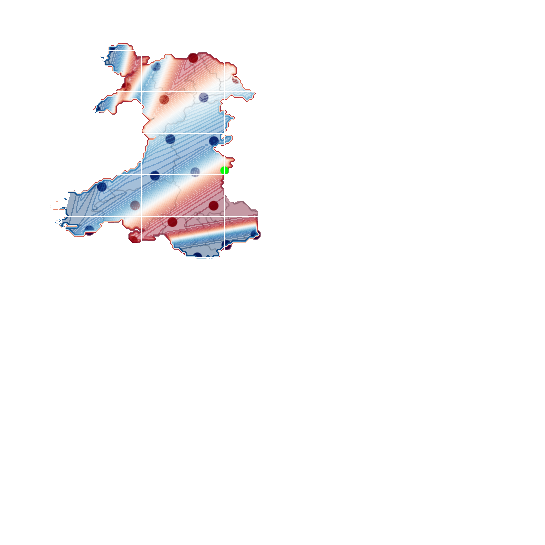

iteration  1
Accuracy is 0.502595654681792
iteration  2
Accuracy is 0.5014420303787733
iteration  3
Accuracy is 0.533358969428956
iteration  4
Accuracy is 0.5356662180349933
iteration  5
Accuracy is 0.5264372236108441
iteration  6
Accuracy is 0.5241299750048067
iteration  7
Accuracy is 0.5252835993078254
iteration  8
Accuracy is 0.5247067871563161
iteration  9
Accuracy is 0.5127860026917901
iteration  10
Accuracy is 0.5206691020957508
iteration  11
Accuracy is 0.5172082291866948
iteration  12
Accuracy is 0.5154777927321669
iteration  13
Accuracy is 0.5141318977119784
iteration  14
Accuracy is 0.5156700634493366
iteration  15
Accuracy is 0.5189386656412228
iteration  16
Accuracy is 0.5118246491059412
iteration  17
Accuracy is 0.5187463949240531
iteration  18
Accuracy is 0.517977312055374
iteration  19
Accuracy is 0.5039415497019804
iteration  20
Accuracy is 0.5147087098634878
iteration  21
Accuracy is 0.5089405883483945
experiment:  4


<IPython.core.display.Javascript object>


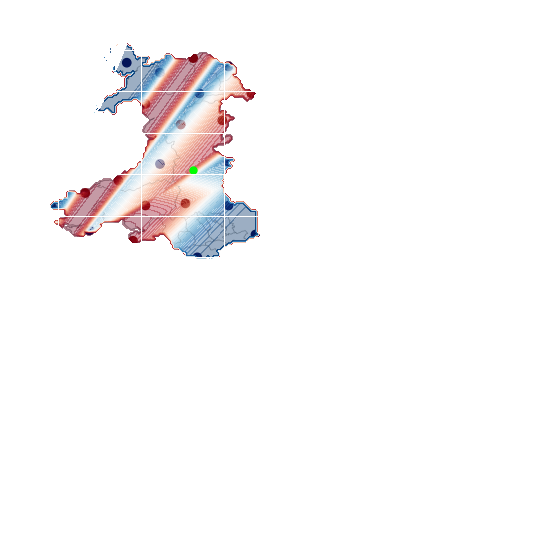

iteration  1
Accuracy is 0.5175927706210344
iteration  2
Accuracy is 0.5325898865602768
iteration  3
Accuracy is 0.5370121130551817
iteration  4
Accuracy is 0.535089405883484
iteration  5
Accuracy is 0.5248990578734859
iteration  6
Accuracy is 0.5241299750048067
iteration  7
Accuracy is 0.5229763507017882
iteration  8
Accuracy is 0.522207267833109
iteration  9
Accuracy is 0.5189386656412228
iteration  10
Accuracy is 0.5220149971159392
iteration  11
Accuracy is 0.5208613728129206
iteration  12
Accuracy is 0.5183618534897135
iteration  13
Accuracy is 0.520476831378581
iteration  14
Accuracy is 0.5164391463180158
iteration  15
Accuracy is 0.5229763507017882
iteration  16
Accuracy is 0.516246875600846
iteration  17
Accuracy is 0.5212459142472602
iteration  18
Accuracy is 0.5177850413382042
iteration  19
Accuracy is 0.5074024226110363
iteration  20
Accuracy is 0.4975966160353778
iteration  21
Accuracy is 0.5152855220149971
experiment:  5


<IPython.core.display.Javascript object>


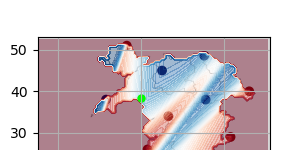

iteration  1
Accuracy is 0.47510094212651416
iteration  2
Accuracy is 0.50432609113632
iteration  3
Accuracy is 0.49663526244952894
iteration  4
Accuracy is 0.4975966160353778
iteration  5
Accuracy is 0.4983656989040569
iteration  6
Accuracy is 0.49740434531820804
iteration  7
Accuracy is 0.5139396269948087
iteration  8
Accuracy is 0.5293212843683907
iteration  9
Accuracy is 0.5039415497019804
iteration  10
Accuracy is 0.5037492789848106
iteration  11
Accuracy is 0.5081715054797155
iteration  12
Accuracy is 0.5029801961161315
iteration  13
Accuracy is 0.502595654681792
iteration  14
Accuracy is 0.5225918092674485
iteration  15
Accuracy is 0.5174004999038646
iteration  16
Accuracy is 0.49202076523745436
iteration  17
Accuracy is 0.5024033839646221
iteration  18
Accuracy is 0.49048259950009615
iteration  19
Accuracy is 0.500865218227264
iteration  20
Accuracy is 0.5047106325706595
iteration  21
Accuracy is 0.4908671409344357
experiment:  6


<IPython.core.display.Javascript object>


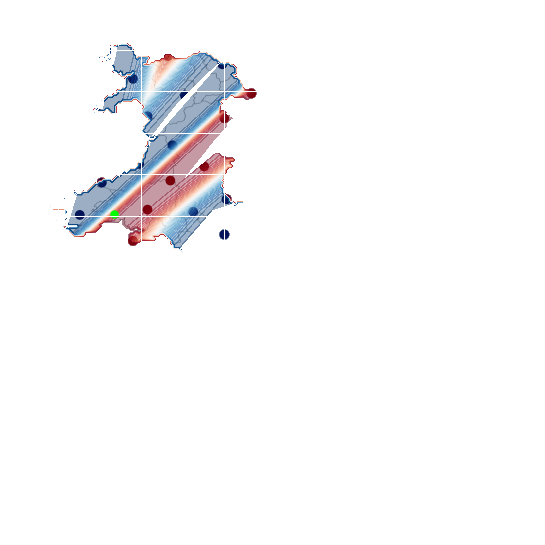

iteration  1
Accuracy is 0.5323976158431071
iteration  2
Accuracy is 0.5477792732166891
iteration  3
Accuracy is 0.5106710248029225
iteration  4
Accuracy is 0.5027879253989618
iteration  5
Accuracy is 0.49894251105556625
iteration  6
Accuracy is 0.4983656989040569
iteration  7
Accuracy is 0.5016343010959431
iteration  8
Accuracy is 0.5004806767929244
iteration  9
Accuracy is 0.49894251105556625
iteration  10
Accuracy is 0.4962507210151894
iteration  11
Accuracy is 0.4962507210151894
iteration  12
Accuracy is 0.4962507210151894
iteration  13
Accuracy is 0.49817342818688715
iteration  14
Accuracy is 0.49413574312632186
iteration  15
Accuracy is 0.5016343010959431
iteration  16
Accuracy is 0.5047106325706595
iteration  17
Accuracy is 0.5049029032878293
iteration  18
Accuracy is 0.502595654681792
iteration  19
Accuracy is 0.5039415497019804
iteration  20
Accuracy is 0.5029801961161315
iteration  21
Accuracy is 0.4999038646414151
experiment:  7


<IPython.core.display.Javascript object>


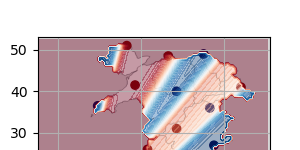

iteration  1
Accuracy is 0.46837146702557203
iteration  2
Accuracy is 0.4608729090559508
iteration  3
Accuracy is 0.49259757738896365
iteration  4
Accuracy is 0.4935589309748125
iteration  5
Accuracy is 0.4952893674293405
iteration  6
Accuracy is 0.5052874447221688
iteration  7
Accuracy is 0.49336666025764275
iteration  8
Accuracy is 0.4877908094597193
iteration  9
Accuracy is 0.4968275331666987
iteration  10
Accuracy is 0.5164391463180158
iteration  11
Accuracy is 0.5006729475100942
iteration  12
Accuracy is 0.499134781772736
iteration  13
Accuracy is 0.4927898481061334
iteration  14
Accuracy is 0.493174389540473
iteration  15
Accuracy is 0.4902903287829264
iteration  16
Accuracy is 0.4891367044799077
iteration  17
Accuracy is 0.46721784272255334
iteration  18
Accuracy is 0.46510286483368585
iteration  19
Accuracy is 0.48413766583349355
iteration  20
Accuracy is 0.46644875985387424
iteration  21
Accuracy is 0.491443953085945
experiment:  8


<IPython.core.display.Javascript object>


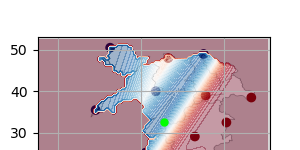

iteration  1
Accuracy is 0.5066333397423572
iteration  2
Accuracy is 0.5052874447221688
iteration  3
Accuracy is 0.4691405498942511
iteration  4
Accuracy is 0.4875985387425495
iteration  5
Accuracy is 0.4862526437223611
iteration  6
Accuracy is 0.5143241684291482
iteration  7
Accuracy is 0.5150932512978273
iteration  8
Accuracy is 0.5131705441261296
iteration  9
Accuracy is 0.517977312055374
iteration  10
Accuracy is 0.5289367429340511
iteration  11
Accuracy is 0.5272063064795232
iteration  12
Accuracy is 0.5066333397423572
iteration  13
Accuracy is 0.5062487983080177
iteration  14
Accuracy is 0.5095174004999039
iteration  15
Accuracy is 0.5266294943280139
iteration  16
Accuracy is 0.5052874447221688
iteration  17
Accuracy is 0.5248990578734859
iteration  18
Accuracy is 0.5075946933282061
iteration  19
Accuracy is 0.5193232070755623
iteration  20
Accuracy is 0.5106710248029225
iteration  21
Accuracy is 0.5168236877523553
experiment:  9


<IPython.core.display.Javascript object>


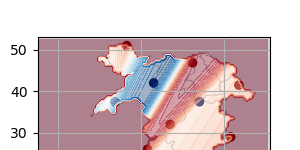

iteration  1
Accuracy is 0.5331666987117862
iteration  2
Accuracy is 0.5323976158431071
iteration  3
Accuracy is 0.5295135550855604
iteration  4
Accuracy is 0.5308594501057489
iteration  5
Accuracy is 0.5285522014997116
iteration  6
Accuracy is 0.5306671793885791
iteration  7
Accuracy is 0.5327821572774466
iteration  8
Accuracy is 0.5087483176312247
iteration  9
Accuracy is 0.52143818496443
iteration  10
Accuracy is 0.5293212843683907
iteration  11
Accuracy is 0.5091328590655643
iteration  12
Accuracy is 0.5314362622572583
iteration  13
Accuracy is 0.5285522014997116
iteration  14
Accuracy is 0.5287444722168814
iteration  15
Accuracy is 0.5370121130551817
iteration  16
Accuracy is 0.5323976158431071
iteration  17
Accuracy is 0.534128052297635
iteration  18
Accuracy is 0.5414343395500866
iteration  19
Accuracy is 0.5383580080753702
iteration  20
Accuracy is 0.5348971351663142
iteration  21
Accuracy is 0.5335512401461258
experiment:  10


<IPython.core.display.Javascript object>


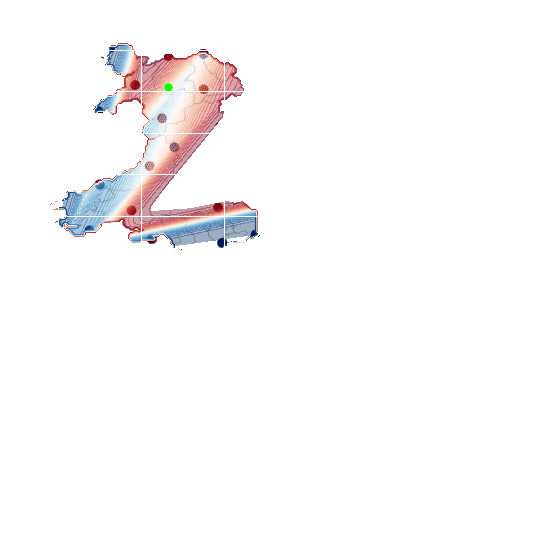

iteration  1
Accuracy is 0.4843299365506633
iteration  2
Accuracy is 0.5177850413382042
iteration  3
Accuracy is 0.5024033839646221
iteration  4
Accuracy is 0.5189386656412228
iteration  5
Accuracy is 0.5170159584695251
iteration  6
Accuracy is 0.516246875600846
iteration  7
Accuracy is 0.5200922899442415
iteration  8
Accuracy is 0.5141318977119784
iteration  9
Accuracy is 0.5202845606614113
iteration  10
Accuracy is 0.5208613728129206
iteration  11
Accuracy is 0.5202845606614113
iteration  12
Accuracy is 0.5135550855604691
iteration  13
Accuracy is 0.519707748509902
iteration  14
Accuracy is 0.5199000192270717
iteration  15
Accuracy is 0.5120169198231109
iteration  16
Accuracy is 0.5154777927321669
iteration  17
Accuracy is 0.5199000192270717
iteration  18
Accuracy is 0.5122091905402807
iteration  19
Accuracy is 0.5200922899442415
iteration  20
Accuracy is 0.5235531628532974
iteration  21
Accuracy is 0.5260526821765045
experiment:  11


<IPython.core.display.Javascript object>


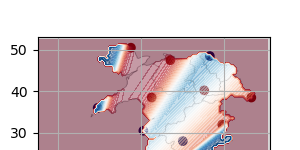

iteration  1
Accuracy is 0.5097096712170737
iteration  2
Accuracy is 0.5100942126514132
iteration  3
Accuracy is 0.5300903672370698
iteration  4
Accuracy is 0.5389348202268794
iteration  5
Accuracy is 0.5300903672370698
iteration  6
Accuracy is 0.5083637761968852
iteration  7
Accuracy is 0.52143818496443
iteration  8
Accuracy is 0.5077869640453759
iteration  9
Accuracy is 0.5052874447221688
iteration  10
Accuracy is 0.5241299750048067
iteration  11
Accuracy is 0.5223995385502788
iteration  12
Accuracy is 0.5231686214189579
iteration  13
Accuracy is 0.5108632955200922
iteration  14
Accuracy is 0.5118246491059412
iteration  15
Accuracy is 0.5143241684291482
iteration  16
Accuracy is 0.5095174004999039
iteration  17
Accuracy is 0.5154777927321669
iteration  18
Accuracy is 0.506825610459527
iteration  19
Accuracy is 0.4891367044799077
iteration  20
Accuracy is 0.47567775427802345
iteration  21
Accuracy is 0.4843299365506633
experiment:  12


<IPython.core.display.Javascript object>


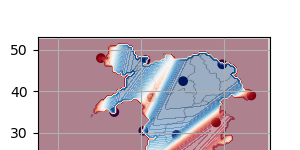

iteration  1
Accuracy is 0.47337050567198613
iteration  2
Accuracy is 0.47798500288406076
iteration  3
Accuracy is 0.4960584502980196
iteration  4
Accuracy is 0.49855796962122667
iteration  5
Accuracy is 0.47971543933858873
iteration  6
Accuracy is 0.49740434531820804
iteration  7
Accuracy is 0.4877908094597193
iteration  8
Accuracy is 0.49048259950009615
iteration  9
Accuracy is 0.5074024226110363
iteration  10
Accuracy is 0.49202076523745436
iteration  11
Accuracy is 0.5035570082676408
iteration  12
Accuracy is 0.493174389540473
iteration  13
Accuracy is 0.4935589309748125
iteration  14
Accuracy is 0.49452028456066144
iteration  15
Accuracy is 0.4960584502980196
iteration  16
Accuracy is 0.47644683714670255
iteration  17
Accuracy is 0.47683137858104213
iteration  18
Accuracy is 0.47875408575273987
iteration  19
Accuracy is 0.476062295712363
iteration  20
Accuracy is 0.48336858296481444
iteration  21
Accuracy is 0.4831763122476447
experiment:  13


<IPython.core.display.Javascript object>


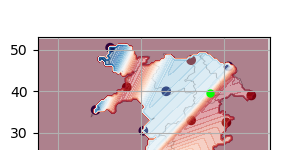

iteration  1
Accuracy is 0.5014420303787733
iteration  2
Accuracy is 0.4845222072678331
iteration  3
Accuracy is 0.4845222072678331
iteration  4
Accuracy is 0.4845222072678331
iteration  5
Accuracy is 0.4883676216112286
iteration  6
Accuracy is 0.4870217265910402
iteration  7
Accuracy is 0.4810613343587772
iteration  8
Accuracy is 0.477792732166891
iteration  9
Accuracy is 0.5091328590655643
iteration  10
Accuracy is 0.48721399730820997
iteration  11
Accuracy is 0.4770236492982119
iteration  12
Accuracy is 0.49452028456066144
iteration  13
Accuracy is 0.49009805806575657
iteration  14
Accuracy is 0.49009805806575657
iteration  15
Accuracy is 0.4714477985002884
iteration  16
Accuracy is 0.4722168813689675
iteration  17
Accuracy is 0.47490867140934434
iteration  18
Accuracy is 0.4737550471063257
iteration  19
Accuracy is 0.48183041722745623
iteration  20
Accuracy is 0.47798500288406076
iteration  21
Accuracy is 0.4752932128436839
experiment:  14


<IPython.core.display.Javascript object>


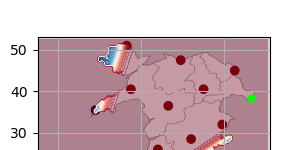

iteration  1
Accuracy is 0.46241107479330895
iteration  2
Accuracy is 0.4947125552778312
iteration  3
Accuracy is 0.4968275331666987
iteration  4
Accuracy is 0.50432609113632
iteration  5
Accuracy is 0.5039415497019804
iteration  6
Accuracy is 0.499134781772736
iteration  7
Accuracy is 0.499134781772736
iteration  8
Accuracy is 0.5054797154393386
iteration  9
Accuracy is 0.5106710248029225
iteration  10
Accuracy is 0.5124014612574505
iteration  11
Accuracy is 0.5141318977119784
iteration  12
Accuracy is 0.5131705441261296
iteration  13
Accuracy is 0.5039415497019804
iteration  14
Accuracy is 0.5029801961161315
iteration  15
Accuracy is 0.5045183618534897
iteration  16
Accuracy is 0.5016343010959431
iteration  17
Accuracy is 0.5022111132474524
iteration  18
Accuracy is 0.4968275331666987
iteration  19
Accuracy is 0.5006729475100942
iteration  20
Accuracy is 0.502595654681792
iteration  21
Accuracy is 0.5012497596616036
experiment:  15


<IPython.core.display.Javascript object>


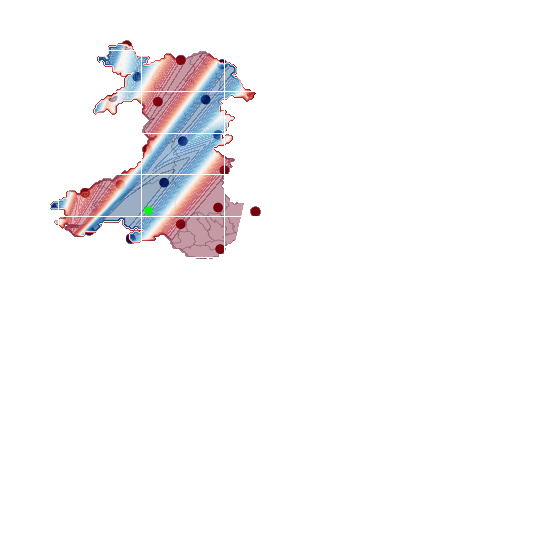

iteration  1
Accuracy is 0.5029801961161315
iteration  2
Accuracy is 0.5243222457219765
iteration  3
Accuracy is 0.5360507594693328
iteration  4
Accuracy is 0.5077869640453759
iteration  5
Accuracy is 0.5260526821765045
iteration  6
Accuracy is 0.534128052297635
iteration  7
Accuracy is 0.5335512401461258
iteration  8
Accuracy is 0.5210536435300903
iteration  9
Accuracy is 0.5323976158431071
iteration  10
Accuracy is 0.533358969428956
iteration  11
Accuracy is 0.5314362622572583
iteration  12
Accuracy is 0.5172082291866948
iteration  13
Accuracy is 0.5231686214189579
iteration  14
Accuracy is 0.5229763507017882
iteration  15
Accuracy is 0.5283599307825418
iteration  16
Accuracy is 0.5166314170351856
iteration  17
Accuracy is 0.506825610459527
iteration  18
Accuracy is 0.5022111132474524
iteration  19
Accuracy is 0.5047106325706595
iteration  20
Accuracy is 0.5087483176312247
iteration  21
Accuracy is 0.5131705441261296
experiment:  16


<IPython.core.display.Javascript object>


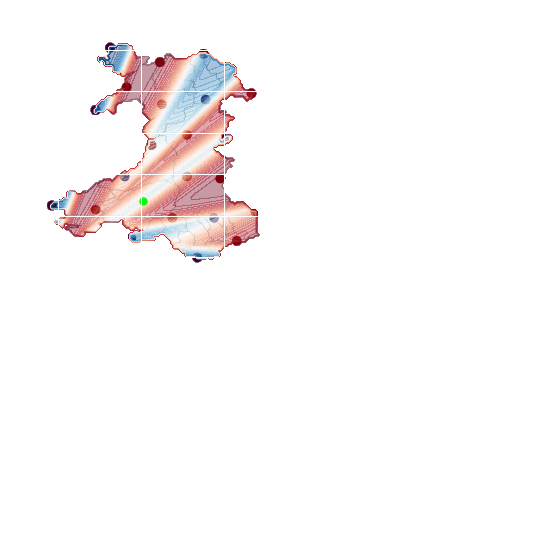

iteration  1
Accuracy is 0.5147087098634878
iteration  2
Accuracy is 0.5091328590655643
iteration  3
Accuracy is 0.5091328590655643
iteration  4
Accuracy is 0.5089405883483945
iteration  5
Accuracy is 0.5335512401461258
iteration  6
Accuracy is 0.5347048644491444
iteration  7
Accuracy is 0.5297058258027303
iteration  8
Accuracy is 0.5302826379542396
iteration  9
Accuracy is 0.519707748509902
iteration  10
Accuracy is 0.5318208036915978
iteration  11
Accuracy is 0.5143241684291482
iteration  12
Accuracy is 0.5160546048836763
iteration  13
Accuracy is 0.5108632955200922
iteration  14
Accuracy is 0.5002884060757546
iteration  15
Accuracy is 0.49567390886368007
iteration  16
Accuracy is 0.4979811574697174
iteration  17
Accuracy is 0.493174389540473
iteration  18
Accuracy is 0.4802922514900981
iteration  19
Accuracy is 0.47125552778311863
iteration  20
Accuracy is 0.4783695443184003
iteration  21
Accuracy is 0.4822149586617958
experiment:  17


<IPython.core.display.Javascript object>


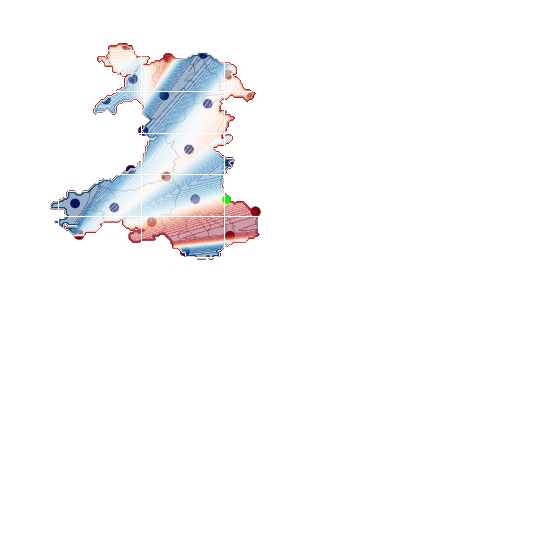

iteration  1
Accuracy is 0.5485483560853682
iteration  2
Accuracy is 0.510286483368583
iteration  3
Accuracy is 0.5114401076716016
iteration  4
Accuracy is 0.5018265718131129
iteration  5
Accuracy is 0.49894251105556625
iteration  6
Accuracy is 0.5074024226110363
iteration  7
Accuracy is 0.506056527590848
iteration  8
Accuracy is 0.5079792347625457
iteration  9
Accuracy is 0.5083637761968852
iteration  10
Accuracy is 0.5006729475100942
iteration  11
Accuracy is 0.5075946933282061
iteration  12
Accuracy is 0.5029801961161315
iteration  13
Accuracy is 0.4999038646414151
iteration  14
Accuracy is 0.5014420303787733
iteration  15
Accuracy is 0.5014420303787733
iteration  16
Accuracy is 0.4806767929244376
iteration  17
Accuracy is 0.4858681022880215
iteration  18
Accuracy is 0.49009805806575657
iteration  19
Accuracy is 0.4850990194193424
iteration  20
Accuracy is 0.5024033839646221
iteration  21
Accuracy is 0.5010574889444338
experiment:  18


<IPython.core.display.Javascript object>


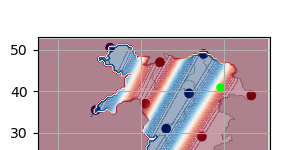

iteration  1
Accuracy is 0.5137473562776389
iteration  2
Accuracy is 0.5518169582772544
iteration  3
Accuracy is 0.5510478754085752
iteration  4
Accuracy is 0.5216304556815997
iteration  5
Accuracy is 0.5216304556815997
iteration  6
Accuracy is 0.5054797154393386
iteration  7
Accuracy is 0.5031724668333013
iteration  8
Accuracy is 0.5024033839646221
iteration  9
Accuracy is 0.5081715054797155
iteration  10
Accuracy is 0.5020188425302826
iteration  11
Accuracy is 0.5058642568736781
iteration  12
Accuracy is 0.534128052297635
iteration  13
Accuracy is 0.5329744279946165
iteration  14
Accuracy is 0.5298980965199
iteration  15
Accuracy is 0.5245145164391464
iteration  16
Accuracy is 0.5072101518938665
iteration  17
Accuracy is 0.49336666025764275
iteration  18
Accuracy is 0.500865218227264
iteration  19
Accuracy is 0.5077869640453759
iteration  20
Accuracy is 0.5049029032878293
iteration  21
Accuracy is 0.5039415497019804
experiment:  19


<IPython.core.display.Javascript object>


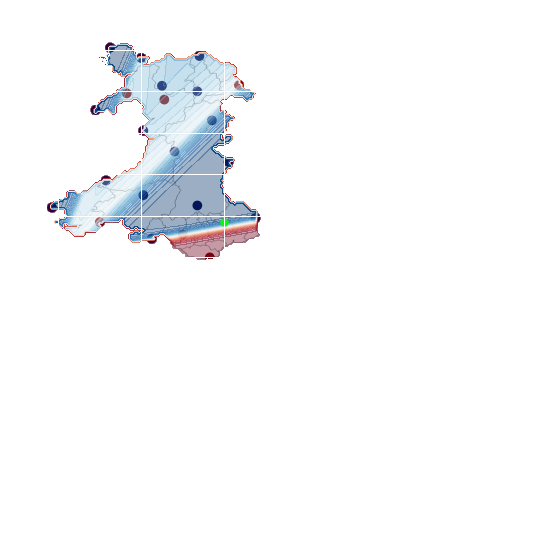

iteration  1
Accuracy is 0.5291290136512209
iteration  2
Accuracy is 0.5283599307825418
iteration  3
Accuracy is 0.5281676600653721
iteration  4
Accuracy is 0.5143241684291482
iteration  5
Accuracy is 0.5189386656412228
iteration  6
Accuracy is 0.5343203230148048
iteration  7
Accuracy is 0.5410497981157469
iteration  8
Accuracy is 0.5410497981157469
iteration  9
Accuracy is 0.5377811959238608
iteration  10
Accuracy is 0.5356662180349933
iteration  11
Accuracy is 0.5287444722168814
iteration  12
Accuracy is 0.5281676600653721
iteration  13
Accuracy is 0.5125937319746202
iteration  14
Accuracy is 0.5093251297827341
iteration  15
Accuracy is 0.5137473562776389
iteration  16
Accuracy is 0.5195154777927322
iteration  17
Accuracy is 0.5185541242068833
iteration  18
Accuracy is 0.48932897519707746
iteration  19
Accuracy is 0.5016343010959431
iteration  20
Accuracy is 0.5029801961161315
iteration  21
Accuracy is 0.5122091905402807
experiment:  20


<IPython.core.display.Javascript object>


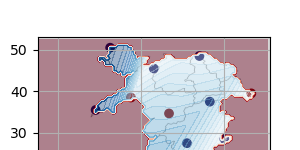

iteration  1
Accuracy is 0.5127860026917901
iteration  2
Accuracy is 0.5106710248029225
iteration  3
Accuracy is 0.5343203230148048
iteration  4
Accuracy is 0.5356662180349933
iteration  5
Accuracy is 0.5347048644491444
iteration  6
Accuracy is 0.5304749086714093
iteration  7
Accuracy is 0.5273985771966929
iteration  8
Accuracy is 0.5260526821765045
iteration  9
Accuracy is 0.5000961353585849
iteration  10
Accuracy is 0.5141318977119784
iteration  11
Accuracy is 0.5206691020957508
iteration  12
Accuracy is 0.52143818496443
iteration  13
Accuracy is 0.5293212843683907
iteration  14
Accuracy is 0.5306671793885791
iteration  15
Accuracy is 0.5258604114593347
iteration  16
Accuracy is 0.5168236877523553
iteration  17
Accuracy is 0.516246875600846
iteration  18
Accuracy is 0.49413574312632186
iteration  19
Accuracy is 0.48932897519707746
iteration  20
Accuracy is 0.4822149586617958
iteration  21
Accuracy is 0.4999038646414151


In [7]:
from random import randint
import time

valid_seeds = [12,15,17,21,23,24,25,31,35,36,37,41,43,45,49,52,55,56,57,58,59]

Results = []

for j in range(len(valid_seeds)):
    
    random.seed(valid_seeds[j])

    print('experiment: ',j)                            

    num = 100
    x = np.linspace(-5, 51, num)
    y = np.linspace(-2, 53, num)
    global landpoints 
    landpoints = []

    for i in range(num):
        for j in range(num):
            if wales.contains_points([(x[i],y[j])]):
                landpoints.append([x[i],y[j]])

    landpoints = np.asarray(landpoints, dtype=np.float32)

    i=0 
    coords = []

    for i in range(numcoords):
        value = randint(0, landpoints.size/2)
        coords.append((landpoints[value][0],
                            landpoints[value][1],
                            eggholderColor(landpoints[value],threshold_low,threshold_high)))
        i+=1

    global fig1,ax
    fig1, ax = plt.subplots(figsize = (3,3))
    ax.set_xlim(-5,51)
    ax.set_ylim(-2,53)
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic')
    # plt.axis("off")
    plt.grid()
    # cid = fig1.canvas.mpl_connect('button_press_event', Helicopter)

    fig1.show()
    fig1.canvas.draw()

    global accuracyArray
    accuracyArray = []

    for i in range(maxiter):
        plt.pause(1)
        print('iteration ',i+1)
    #     print('Calculating Model... ')
        calculateModel()
        plt.pause(1)
        fig1.canvas.draw()    
        Accuracy()
    #     print('Finding Isolated Point')
        if(i!=maxiter):
                     #0 for 0.5, 1 for isolated, 2 for random

            if(selection_model == 0):    
                nextpoint = find0_5()
            elif(selection_model==1):
                nextpoint=find_isolated_point()
            elif(selection_model==2):
                nextpoint = random_point()
            elif(selection_model==3):
                nextpoint = best()
            plt.pause(1)
            fig1.canvas.draw()
            coords.append((nextpoint[0], nextpoint[1], eggholderColor(nextpoint,threshold_low,threshold_high)))  
            plt.pause(1)
            fig1.canvas.draw()

    plt.close()
    
    Results.append(accuracyArray)
    
    

In [8]:
print('Highest Accuracy =',"{:.2f}".format((max(accuracyArray)*100)),'%')
print('Improvement is =', "{:.2f}".format((max(accuracyArray)-accuracyArray[0])*100),'%')

Highest Accuracy = 53.57 %
Improvement is = 2.29 %


In [9]:
Results

[[0.5037492789848106,
  0.5041338204191501,
  0.5387425495097097,
  0.5373966544895212,
  0.5206691020957508,
  0.5143241684291482,
  0.5379734666410305,
  0.5387425495097097,
  0.5325898865602768,
  0.5331666987117862,
  0.5235531628532974,
  0.5283599307825418,
  0.531628532974428,
  0.5379734666410305,
  0.499134781772736,
  0.4866371851567006,
  0.48894443376273794,
  0.4887521630455682,
  0.4754854835608537,
  0.4814458757931167,
  0.4737550471063257],
 [0.5370121130551817,
  0.5097096712170737,
  0.5091328590655643,
  0.4964429917323592,
  0.49009805806575657,
  0.49009805806575657,
  0.5002884060757546,
  0.5000961353585849,
  0.50432609113632,
  0.49182849452028454,
  0.4822149586617958,
  0.4979811574697174,
  0.49701980388386846,
  0.4960584502980196,
  0.4845222072678331,
  0.48567583157085176,
  0.4745241299750048,
  0.47971543933858873,
  0.49490482599500096,
  0.48740626802537973,
  0.485483560853682],
 [0.49740434531820804,
  0.4952893674293405,
  0.49817342818688715,
  

In [10]:
np.savetxt('eggholderIsolatednn', Results)